In [2]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

from random import randint
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Acquisition des images

In [4]:
data_dir  = '/content/drive/MyDrive/GMC1041/dataset_papertrash/'

classes = os.listdir(data_dir)
print(classes)

['paper', 'trash']


In [5]:
transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
dataset = ImageFolder(data_dir, transform = transformations)

In [6]:
dataset

Dataset ImageFolder
    Number of datapoints: 434
    Root location: /content/drive/MyDrive/GMC1041/data2/
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

# Visualisation d'image

In [7]:
def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))
    plt.title(dataset.classes[label])

Label: trash (Class No: 1)
Label: paper (Class No: 0)
Label: paper (Class No: 0)
Label: paper (Class No: 0)
Label: paper (Class No: 0)
Label: paper (Class No: 0)
Label: trash (Class No: 1)
Label: paper (Class No: 0)
Label: paper (Class No: 0)
Label: trash (Class No: 1)
Label: paper (Class No: 0)
Label: paper (Class No: 0)
Label: paper (Class No: 0)


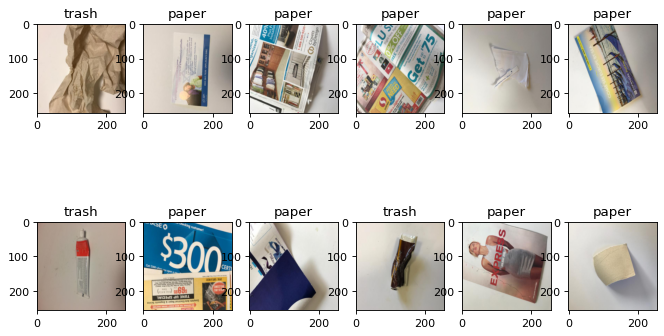

In [9]:
figure(figsize = (10, 6), dpi = 80)
for i in range(12):
    plt.subplot(2,6,i+1)
    rint = randint(0,434)
    img, label = dataset[rint]
    show_sample(img, label)
    plt.show
img, label = dataset[12]
show_sample(img, label)

# Jeu de validation

In [10]:
random_seed = 42
torch.manual_seed(random_seed)

In [11]:
train_ds, val_ds, test_ds = random_split(dataset, [350, 50, 34])
len(train_ds), len(val_ds), len(test_ds)

(350, 50, 34)

In [12]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

In [13]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_ds)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [14]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

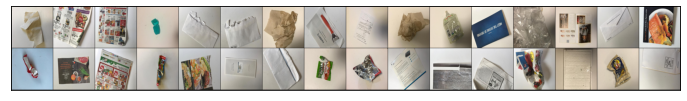

In [15]:
show_batch(train_dl)

# Creation du modele

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [17]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [18]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [19]:
device = get_default_device()
device

device(type='cpu')

In [20]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [21]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [22]:
model = to_device(ResNet(), device)

In [23]:
evaluate(model, val_dl)

{'val_loss': 0.6660335063934326, 'val_acc': 0.6399999856948853}

In [24]:
num_epochs = 8
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 0.5938, val_loss: 0.5535, val_acc: 0.7000
Epoch 2: train_loss: 0.4282, val_loss: 0.4256, val_acc: 0.9200
Epoch 3: train_loss: 0.3397, val_loss: 0.3663, val_acc: 0.9800
Epoch 4: train_loss: 0.3234, val_loss: 0.3465, val_acc: 0.9800
Epoch 5: train_loss: 0.3192, val_loss: 0.3393, val_acc: 0.9800
Epoch 6: train_loss: 0.3180, val_loss: 0.3349, val_acc: 0.9800
Epoch 7: train_loss: 0.3209, val_loss: 0.3495, val_acc: 0.9800
Epoch 8: train_loss: 0.3161, val_loss: 0.3490, val_acc: 0.9600


In [25]:
test_dl

# Construction d'une matrice de confusion

In [26]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_dl:
    output = model(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction
        
    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

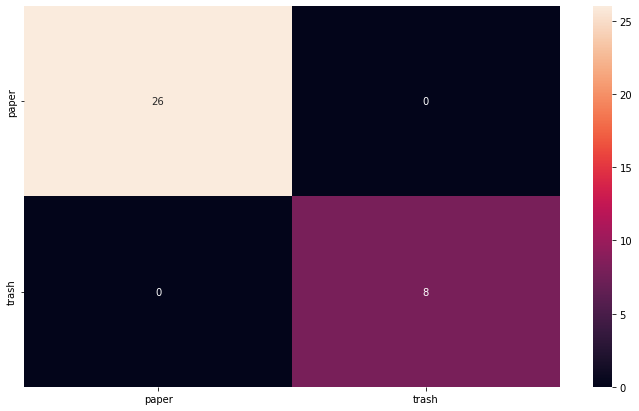

In [27]:
# constant for classes
classes = ('paper', 'trash')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

# Graphique d'apprentissage

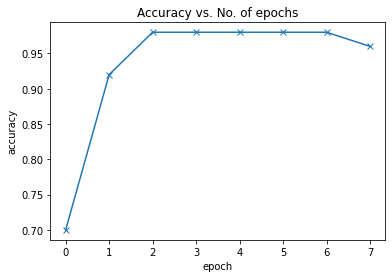

In [28]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

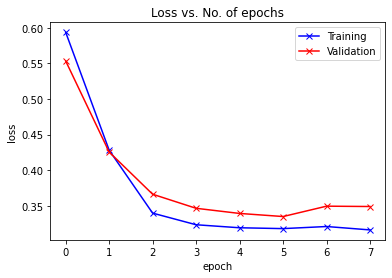

In [29]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

# Voir une prediction in testset

In [30]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: paper , Predicted: paper


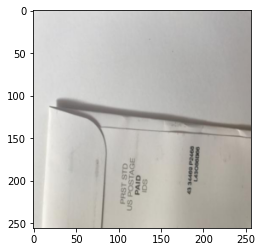

In [32]:
img, label = test_ds[11]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: paper , Predicted: paper


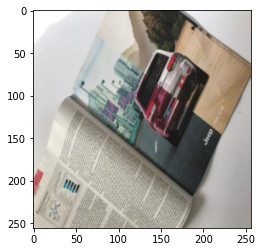

In [33]:
img, label = test_ds[22]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))